Extract temperature profiles for each month of the year at specified positions from a SeadataNet climatology.

In [150]:
import numpy as np
import glob
import os
import matplotlib.pyplot as plt
import netCDF4
import calendar
from matplotlib import rcParams
from mpl_toolkits.basemap import Basemap
from geopy.distance import vincenty
%matplotlib inline

In [153]:
rcParams.update({'font.size': 16})

In [107]:
coordinatelist = [(2. + 10. / 60., 39. + 21. / 60.)]

In [165]:
climdir = "/home/ctroupin/DataOceano/SeaDataNet"
climfile = os.path.join(climdir, 'Temperature.19002013.4Danl.nc')
figdir = '/home/ctroupin/'
climfile

'/home/ctroupin/DataOceano/SeaDataNet/Temperature.19002013.4Danl.nc'

# Load data and coordinates

In [11]:
def load_clim(climfile):
    '''Load the coordinates (lon, lat, depth, time) from the netCDF file'''
    with netCDF4.Dataset(climfile) as nc:
        lon = nc.variables['lon'][:]
        lat = nc.variables['lat'][:]
        depth = nc.variables['depth'][:]
        time = nc.variables['time'][:]
    return lon, lat, depth, time

In [116]:
def get_index_neighbour(coordinates, lon, lat):
    '''
    Get the indices of the coordinates corresponding to the closest points around the point of interest
    imin is the index of the closest longitude grid point smaller than the point of interest
    jmin is the index of the closest latitude grid point smaller than the point of interest
    
    (imin, jmin+1)______________(imin+1, jmin+1)
    |                                  |
    |                      x           |
    |                                  |
    |__________________________________|
    (imin, jmin)                (imin+1, jmin) 
    '''
    deltalon = abs(lon - coordinates[0])
    deltalat = abs(lat - coordinates[1])

    imin = np.argmin(deltalon)
    jmin = np.argmin(deltalat)

    if lon[imin] - coordinates[0] > 0.:   # closest grid point on the right of the point of interest
        imin -= 1

    if lat[jmin] - coordinates[1] > 0.:   # closest grid point on the above of the point of interest
        jmin -= 1
    return imin, jmin

In [91]:
def get_coefficients(coordinates, lon, lat, imin, jmin):
    '''Get the coefficient to perform an inverse distance interpolation 
       using the four closest points.
       The order of the coefficients is shown on the schema.
       
       (1)_______(2)
       |          |
       |       x  |
       |          |
       |__________|
       (0)       (3) 
    '''
    invdist = 1. / np.array((vincenty(coordinates, (lon[imin], lat[jmin])).kilometers,
        vincenty(coordinates, (lon[imin], lat[jmin+1])).kilometers,
        vincenty(coordinates, (lon[imin+1], lat[jmin+1])).kilometers,
        vincenty(coordinates, (lon[imin+1], lat[jmin])).kilometers
        ))
    return invdist / invdist.sum()

In [135]:
def get_variable_neighbour(climfile, variable, imin, jmin):
    with netCDF4.Dataset(climfile) as nc:
        field = nc.variables[variable][:, :, jmin:jmin+2, imin:imin+2]
    return field

In [136]:
lon, lat, depth, time = load_clim(climfile)

In [137]:
for coordinates in coordinatelist:
    print(coordinates)

    #Get the indices for the 4 closest grid points
    imin, jmin = get_index_neighbour(coordinates, lon, lat)
    print(imin, jmin)

    # Compute the coefficients for an inverse distance interpolation
    invdist = get_coefficients(coordinates, lon, lat, imin, jmin)
    print(invdist)

    # Extract the field at the neighbour points 
    field = get_variable_neighbour(climfile, 'Temperature', imin, jmin)
    print(field.shape)

    # Interpolate the field at the selected position
    field_interp = invdist[0] * field[:, :, 0, 0] + invdist[1] * field[:, :, 1, 0] + \
                   invdist[2] * field[:, :, 1, 1] + invdist[3] * field[:, :, 0, 1]
        
    print(field_interp.shape)

(2.1666666666666665, 39.35)
(91, 74)
[ 0.1879039   0.42040772  0.23505798  0.1566304 ]
(12, 33, 2, 2)
(12, 33)


# Plot to check stuffs

In [170]:
fig = plt.figure(figsize=(16, 12))
plt.suptitle('Monthly temperature profiles at (' + str(np.round(coordinates[0], 2)) + 
             '$^{\circ}$E, ' + str(np.round(coordinates[1], 2)) + '$^{\circ}$N)', fontsize=24)
for m in range(0, 12):
    plt.subplot(3, 4, m+1)
    plt.title(calendar.month_name[m+1], fontsize=20)
    plt.plot(field_interp[m, :], -depth, 'ko-', lw=1.5)
    plt.ylim(-75., 0.)
fig.tight_layout()
fig.subplots_adjust(top=0.88)
plt.savefig(os.path.join(figdir, 'temperature_profiles'), dpi=300)
plt.close()

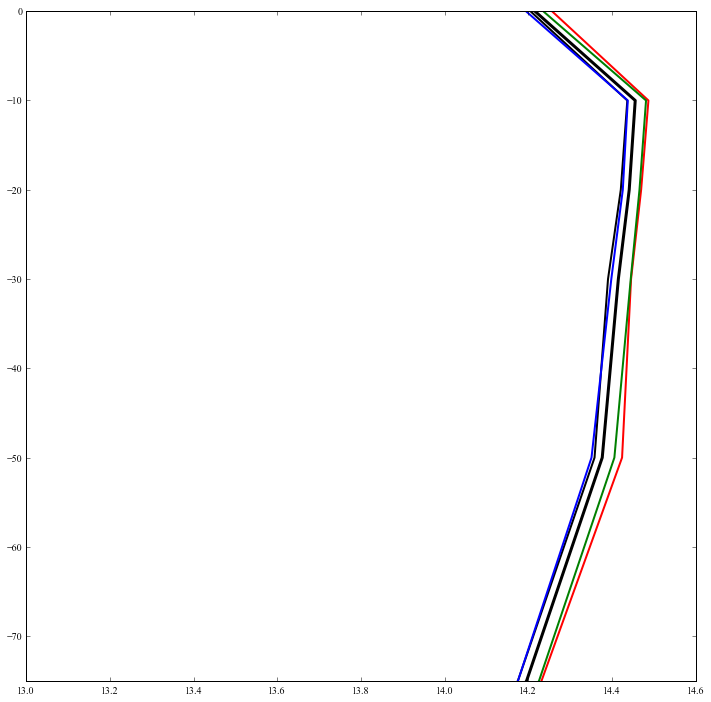

In [133]:
fig = plt.figure(figsize=(12, 12))
plt.plot(field[:,0,0], -depth)
plt.plot(field[:,0,1], -depth, 'r')
plt.plot(field[:,1,0], -depth, 'b')
plt.plot(field[:,1,1], -depth, 'g')
plt.plot(field_interp, -depth, 'k', lw=3)
plt.ylim(-75, 0)
plt.show()